In [3]:
!pip install emoji contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 10.4 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import re
import nltk
import emoji
import contractions
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight
from sklearn.metrics import f1_score , classification_report , confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.losses import BinaryFocalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision , Recall , F1Score
from tensorflow.keras.callbacks import Callback

2025-05-12 23:34:04.522186: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747092844.722241      32 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747092844.777411      32 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [67]:
!wget --no-check-certificate http://nlp.stanford.edu/data/glove.6B.zip -O /kaggle/working/glove.6B.zip

In [5]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [68]:
#Extract the GloVe files
with zipfile.ZipFile('/kaggle/working/glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/glove')

In [6]:
slang_dict = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk",
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart",
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "im" : "i am",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet",
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously",
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

### Preprocessing

In [ ]:
def preprocess_text(text):
    if pd.isna(text): 
        return ""

    text = text.lower() #convert to lowercase
    text = emoji.demojize(text) #convert emojis to alternative text
    text = text.replace(":", "").replace("_", " ") #remove colons and underscores
    text = contractions.fix(text) #expand contractions EX: "don't" to "do not"
    
    #we split the text to check for slang words and replace them
    words = text.split() 
    processed_words = []
    for word in words:
        word_cleaned = word.strip(string.punctuation)
        if word_cleaned.lower() in slang_dict:
            processed_words.append(slang_dict[word_cleaned.lower()])
        else:
            processed_words.append(word)
        text = " ".join(processed_words)

        text = re.sub(r'http\S+|www\S+|https\S+', '', text) #remove URLS
        text = re.sub(r'[^\w\s\.\!\?]', ' ', text) #remove special characters
        text = re.sub(r'\s+', ' ', text).strip() #remove extra spaces

        tokens = word_tokenize(text) #tokenizing the text

        stop_words = set(stopwords.words('english')) #remove stop words
        tokens = [token for token in tokens if token not in stop_words and len(token) > 1]

        lemmatizer = WordNetLemmatizer() #lemmatizing the tokens
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return " ".join(tokens)

In [8]:
df = pd.read_csv('/kaggle/input/tourismmm/labeled_tourism_reviews_binary (1).csv')
df.head()

,Unnamed: 0,attraction,rate,date,review,sentiment,processed_review,review_length,word_count,year,...,negation_count,negation_ratio,has_mixed_sentiment,sentiment_binary,sentiment_score_binary,sentiment_vader,sentiment_score_vader,sentiment_binary_distil,sentiment_score_binary_distil,sentiment_ensemble
0,0,Pyramids of Giza,5.0,2025-02-17,Well worth going to visit. If you are getting ...,1,well worth going visit getting tour fantastic ...,255,49,2025,...,0,0.000000,True,positive,0.998857,positive,0.8357,non_positive,0.671923,positive
1,1,Pyramids of Giza,5.0,2025-02-15,The splendor of the pyramidsThe Seven Wonders ...,1,splendor pyramidsthe seven wonder world seen p...,137,23,2025,...,0,0.000000,False,positive,0.998818,positive,0.7184,positive,0.999620,positive
2,2,Pyramids of Giza,5.0,2025-02-13,The pyramids are among the most beautiful arch...,1,pyramid among beautiful archaeological site wo...,574,90,2025,...,0,0.000000,False,positive,0.998801,positive,0.9524,positive,0.999869,positive
3,3,Pyramids of Giza,5.0,2025-02-09,"yes it crowded, yes there is some tourist trap...",1,yes crowded yes tourist trap yes queue frustra...,310,57,2025,...,0,0.000000,False,positive,0.998868,positive,0.8020,positive,0.990586,positive
4,4,Pyramids of Giza,5.0,2025-02-07,"History & Mystery of The Pyramids, What a Day,...",1,history mystery pyramid day hit visit land leg...,131,23,2025,...,2,0.086957,True,positive,0.998885,positive,0.4667,positive,0.915993,positive


### Balancing the Dataset
* we choose from every attraction site a smple of positive reviews 
* if this attraction site has more than 200 reviews we choose random from them 
* if this sttraction site has less than 200 reviews we take them all

In [ ]:
new_df = df[df['sentiment_ensemble'] == 'non_positive']
for i in df['attraction'].unique():
    tmp = df[(df['attraction'] == i) & (df['sentiment_ensemble'] == 'positive')]
    if tmp.shape[0] > 200:
        tmp = tmp.sample(200 , random_state = 42)
    new_df = pd.concat([new_df , tmp])

In [11]:
X = new_df['review'].apply(lambda x : preprocess_text(x))
y = new_df['sentiment_ensemble'].map({'positive' : 1 , 'non_positive' : 0})

### splitting the data

In [61]:
train_data , test_data , train_labels , test_labels = train_test_split(X , y  , test_size = 0.1 , random_state = 42 , stratify = y , shuffle = True)

In [ ]:
# converting to numpy arrays
train_labels = train_labels.to_numpy()
test_labels = test_labels.to_numpy()

In [ ]:
# we extract the most top 10000 frequent words from the reviews
# but we do not use the words that appear in more than 90% of the reviews
cv = CountVectorizer(ngram_range = (1 , 2) , max_df = 0.9 , max_features=10000)
cv_train_data = cv.fit_transform(train_data)
cv_test_data = cv.transform(test_data)

In [64]:
train_labels.shape

(10517,)

In [65]:
test_labels.shape

(1169,)

In [69]:
td_idf = TfidfVectorizer(ngram_range = (1 , 2) , max_df = 0.9 , max_features=10000)
td_train_data = td_idf.fit_transform(train_data)
td_test_data = td_idf.transform(test_data)

### Modeling

In [ ]:
# Load GloVe Word Embeddings
# Each line in the glove file is like: king 0.123 0.232 ... 0.543   (100 values)
# then we build a Python dictionary embeddings_index that maps each word to its 100-dimensional vector.
# it will look like this : embeddings_index['king'] = [0.123, 0.232, ..., 0.543]

embeddings_index = {} 
glove_file = '/kaggle/working/glove/glove.6B.100d.txt'  # Using 100-dimensional embeddings
with open(glove_file, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print(f'Found {len(embeddings_index)} word vectors.')

Found 400000 word vectors.


In [ ]:
#We Created a Tokenizer that will keep the top 10,000 most frequent words.
#oov_token='<OOV>' is a special token used to handle out-of-vocabulary words.
#It builds word_index: a dictionary that maps each word to a unique integer ID.
#Converts each review in train_data and test_data from text to a list of token IDs.

vocab_size = 10000
tokenizer = Tokenizer(num_words = vocab_size , oov_token='<OOV>')
tokenizer.fit_on_texts(train_data)
word_index = tokenizer.word_index
train_data = tokenizer.texts_to_sequences(train_data)
test_data = tokenizer.texts_to_sequences(test_data)

In [ ]:
# padding all the reviews to the same length 384
maxlen = 384
train_data = pad_sequences(train_data, maxlen=maxlen, padding='post', truncating='post') #padding = post means we add zeros at the end of the reviews shorter than 384
test_data = pad_sequences(test_data, maxlen=maxlen, padding='post', truncating='post') #truncating  = post means we remove the end of the reviews longer than 384

In [ ]:
#we Create a matrix of shape (vocab_size, embedding_dim) to feed into the model’s Embedding layer.
#For each word in the tokenizer’s vocabulary (up to 10,000), it looks up its GloVe vector and adds it to the matrix.
#Words not found in GloVe will have zero vectors.
#we use all of this to load the pretrained embeddings into the Embedding layer of the model instead of training them from scratch

embedding_dim = 100  # Matches glove.6B.100d.txt
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [ ]:
#This class monitors the F1 score (based on precision and recall) on the validation set after each epoch,
#and it stops training early if the F1 score doesn't improve after a number of consecutive epochs (patience).
# it inherits from the Callback class, which is a base class for Keras callbacks.
# it allows you to create custom behaviors during training using callbacks it hooks into the training process using the methods on_epoch_end and on_train_end
class EarlyStoppingF1(Callback): 
    def __init__(self, patience=0, mode='max', restore_best_weights=False):
        super(EarlyStoppingF1, self).__init__()
        self.patience = patience
        self.mode = mode
        self.restore_best_weights = restore_best_weights
        self.best_weights = None
        if mode == 'min':
            self.monitor_op = np.less
            self.best = np.inf
        elif mode == 'max':
            self.monitor_op = np.greater
            self.best = -np.inf
        else:
            raise ValueError('Invalid mode')
        self.wait = 0
        self.stopped_epoch = 0

    def on_epoch_end(self, epoch, logs=None):
        val_precision = logs.get('val_precision')
        val_recall = logs.get('val_recall')
        if val_precision is None or val_recall is None:
            raise ValueError('Validation precision or recall not found in logs')
        # Compute F1 score, avoiding division by zero
        if val_precision + val_recall > 0:
            val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall)
        else:
            val_f1 = 0
        # Check if current F1 score improves over the best
        if self.monitor_op(val_f1, self.best):
            self.best = val_f1
            self.wait = 0
            if self.restore_best_weights:
                self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                if self.restore_best_weights and self.best_weights is not None:
                    self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print(f'Epoch {self.stopped_epoch + 1}: early stopping')

In [ ]:
# we use bidirectional LTSM to process the input in both directions (forward and backward)
# forward from start to end.
# backward from end to start. 
#Ex : "This place is not bad" starting from "This" and starting from "bad" the model realize that the word "not" affects the meaning of "bad"
def bilstm():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen, mask_zero=True))#embedding without the pre-trained weights (Glove)
    model.add(SpatialDropout1D(0.4))#Randomly drops 40% of the entire embedding dimensions 
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.4)) # randomly sets 40% of the neurons to 0
    model.add(Dense(64, activation='relu'))#Dense layer for feature abstraction
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid')) #output layer with sigmoid activation function
    
    model.compile(
        loss=BinaryFocalCrossentropy(apply_class_balancing=True),#helps to handle class imbalance
        optimizer=Adam(learning_rate=0.0001),
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
    )
    return model

In [ ]:
# the same as the last model but with pre-trained embedding weights (Glove)
def pre_bilstm():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen, weights=[embedding_matrix], trainable=False,mask_zero=True))
    model.add(SpatialDropout1D(0.4))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(
        loss=BinaryFocalCrossentropy(apply_class_balancing=True),
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
    )
    return model

In [ ]:
#we added a CNN Layer 
def cnn_bilstm():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen , mask_zero=True))
    model.add(SpatialDropout1D(0.4))
    model.add(Conv1D(filters=64, #no of filters
                     kernel_size=5, #size of the filter
                     activation='relu'))# activation function for non-linearity
    #downsampling operation that reduces the spatial dimensions (sequence length) of the input while retaining the most important features.2 is the size of the pooling window
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.4))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        loss=BinaryFocalCrossentropy(apply_class_balancing=True),
        optimizer=Adam(learning_rate=0.0001),
        metrics=['accuracy' , Precision() , Recall(thresholds=0)]
    )

    return model

In [ ]:
# the same as the last model but adds L2 regularization 
# it penalize large weights in the model, which can help prevent overfitting.
# we added it to all the layers
L2_COEFF = 1e-4
def cnn_bilstm2():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen, embeddings_regularizer=l2(L2_COEFF)))
    model.add(SpatialDropout1D(0.4))
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu', kernel_regularizer=l2(L2_COEFF), bias_regularizer=l2(L2_COEFF)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.4))
    model.add(Bidirectional(LSTM(64, kernel_regularizer=l2(L2_COEFF), recurrent_regularizer=l2(L2_COEFF), bias_regularizer=l2(L2_COEFF))))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(L2_COEFF), bias_regularizer=l2(L2_COEFF)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(L2_COEFF), bias_regularizer=l2(L2_COEFF)))
    
    model.compile(
        loss=BinaryFocalCrossentropy(apply_class_balancing=True),
        optimizer=Adam(learning_rate=0.0001),
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
    )
    return model

In [ ]:
# same as the last model but with pre-trained embedding weights (Glove)
# learning rate is higher because the embedding is not being trained
L2_COEFF = 1e-4
def pre_cnn_bilstm2():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen, weights=[embedding_matrix], trainable=False,mask_zero=True))
    model.add(SpatialDropout1D(0.4))
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu', kernel_regularizer=l2(L2_COEFF), bias_regularizer=l2(L2_COEFF)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.4))
    model.add(Bidirectional(LSTM(64, kernel_regularizer=l2(L2_COEFF), recurrent_regularizer=l2(L2_COEFF), bias_regularizer=l2(L2_COEFF))))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(L2_COEFF), bias_regularizer=l2(L2_COEFF)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(L2_COEFF), bias_regularizer=l2(L2_COEFF)))
    
    model.compile(
        loss=BinaryFocalCrossentropy(apply_class_balancing=True),
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
    )
    return model

In [87]:
models = {'CNN-BiLSTM' : cnn_bilstm2(),
          'BiLSTM' : bilstm(),
          'pre-CNN-BiLSTM' : pre_cnn_bilstm2(),
          'pre-BiLSTM' : pre_bilstm()}

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# training the models
history = {}
for model_name, model in models.items():
    print('-' * 50)
    early_stopping_f1 = EarlyStoppingF1(patience=20, mode='max', restore_best_weights=True)
    history[model_name] = model.fit(
        train_data, train_labels, batch_size=264, epochs=200,
        validation_data=(test_data, test_labels), callbacks=[early_stopping_f1], verbose=1
    )
    print(f'{model_name} finished training')
    save_path = f'/kaggle/working/{model_name}.h5'
    model.save(save_path)
    print(f'{model_name} saved to {save_path}')

--------------------------------------------------
Epoch 1/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.4526 - loss: 0.2186 - precision: 0.5971 - recall: 0.1755 - val_accuracy: 0.4175 - val_loss: 0.2006 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.4217 - loss: 0.1970 - precision: 0.9268 - recall: 5.8408e-04 - val_accuracy: 0.4175 - val_loss: 0.1839 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.4150 - loss: 0.1808 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4175 - val_loss: 0.1698 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.4151 - loss: 0.1670 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4175 - val_loss: 0.1580 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - acc

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'conv1d_5' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.4422 - loss: 0.1365 - precision: 0.5758 - recall: 0.1273 - val_accuracy: 0.4175 - val_loss: 0.1163 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.4243 - loss: 0.1148 - precision: 0.7393 - recall: 0.0298 - val_accuracy: 0.4525 - val_loss: 0.1008 - val_precision: 0.9020 - val_recall: 0.0675
Epoch 3/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.4837 - loss: 0.1024 - precision: 0.7917 - recall: 0.1639 - val_accuracy: 0.5731 - val_loss: 0.0906 - val_precision: 0.9062 - val_recall: 0.2981
Epoch 4/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5717 - loss: 0.0933 - precision: 0.8267 - recall: 0.3285 - val_accuracy: 0.7032 - val_loss: 0.0843 - val_precision: 0.8494 - val_recall: 0.5962
Epoch 5/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.6270 - loss: 0.0866 - precision: 0.8394 - recall: 0.4496 - val_accuracy: 0.6681 - val_loss: 0.0788

In [ ]:
# predicting the test data
pred = {}
for model_name , model in models.items():
    print('-'*50)
    tmp = model.predict(test_data)
    pred[model_name] = (tmp > 0.50).astype(np.int64)
    print(f'{model_name} finished predicting')

--------------------------------------------------
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
CNN-BiLSTM finished predicting
--------------------------------------------------
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
BiLSTM finished predicting
--------------------------------------------------
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
pre-CNN-BiLSTM finished predicting
--------------------------------------------------
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
pre-BiLSTM finished predicting


### Evaluating the models

In [91]:
print(classification_report(test_labels , pred['CNN-BiLSTM']))

              precision    recall  f1-score   support

           0       0.84      0.85      0.84       488
           1       0.89      0.88      0.89       681

    accuracy                           0.87      1169
   macro avg       0.86      0.87      0.86      1169
weighted avg       0.87      0.87      0.87      1169



Text(0.5, 1.0, 'CNN-BILSTM')

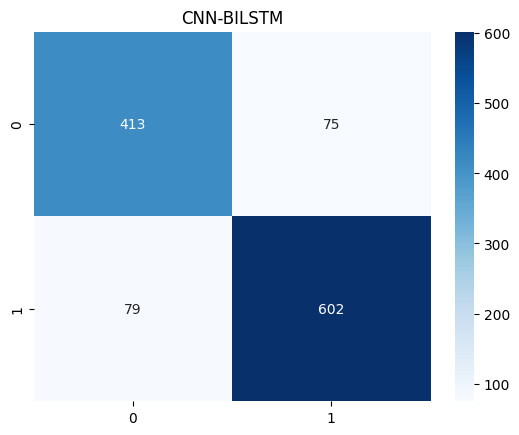

In [101]:
conf = confusion_matrix(test_labels , pred['CNN-BiLSTM'])
sns.heatmap(conf , annot = True , fmt = 'd' , cmap = 'Blues')
plt.title('CNN-BILSTM')

In [92]:
print(classification_report(test_labels , pred['BiLSTM']))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       488
           1       0.91      0.84      0.87       681

    accuracy                           0.86      1169
   macro avg       0.85      0.86      0.86      1169
weighted avg       0.86      0.86      0.86      1169



Text(0.5, 1.0, 'BILSTM')

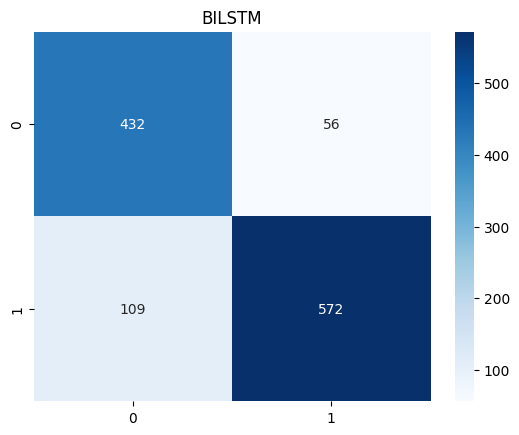

In [102]:
conf = confusion_matrix(test_labels , pred['BiLSTM'])
sns.heatmap(conf , annot = True , fmt = 'd' , cmap = 'Blues')
plt.title('BILSTM')

In [93]:
print(classification_report(test_labels , pred['pre-CNN-BiLSTM']))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       488
           1       0.88      0.86      0.87       681

    accuracy                           0.85      1169
   macro avg       0.84      0.84      0.84      1169
weighted avg       0.85      0.85      0.85      1169



Text(0.5, 1.0, 'pre-CNN-BiLSTM')

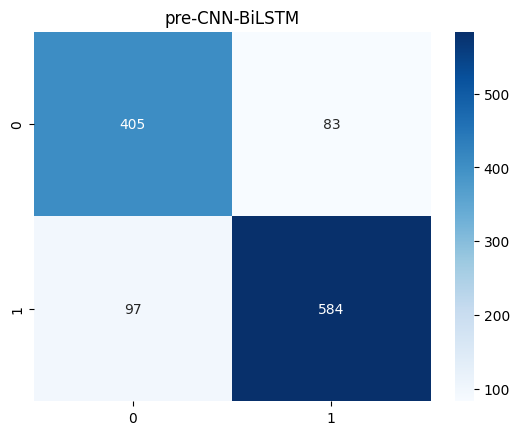

In [103]:
conf = confusion_matrix(test_labels , pred['pre-CNN-BiLSTM'])
sns.heatmap(conf , annot = True , fmt = 'd' , cmap = 'Blues')
plt.title('pre-CNN-BiLSTM')

In [94]:
print(classification_report(test_labels , pred['pre-BiLSTM']))

              precision    recall  f1-score   support

           0       0.79      0.92      0.85       488
           1       0.94      0.82      0.88       681

    accuracy                           0.86      1169
   macro avg       0.86      0.87      0.86      1169
weighted avg       0.87      0.86      0.86      1169



Text(0.5, 1.0, 'pre-BiLSTM')

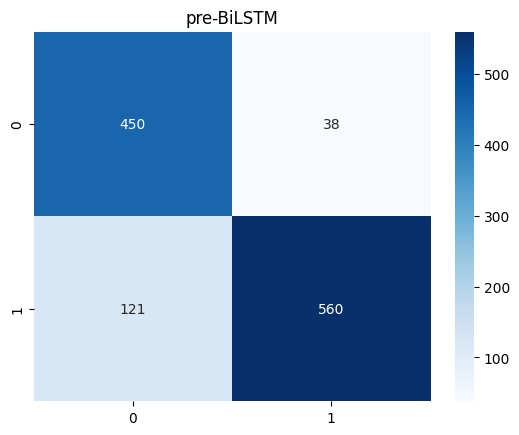

In [104]:
conf = confusion_matrix(test_labels , pred['pre-BiLSTM'])
sns.heatmap(conf , annot = True , fmt = 'd' , cmap = 'Blues')
plt.title('pre-BiLSTM')

In [107]:
best = -np.inf
best_model = ''
for model_name , model in models.items():
    print('-'*50)
    tmp = f1_score(test_labels , pred[model_name])
    if tmp > best:
        best = tmp
        best_model = model_name
    print(model_name,f1_score(test_labels , pred[model_name]))
print('-' * 50)
print(f'Best model in terms of f1-score is {best_model} with score of : {best:.4f}')

--------------------------------------------------
CNN-BiLSTM 0.88659793814433
--------------------------------------------------
BiLSTM 0.8739495798319329
--------------------------------------------------
pre-CNN-BiLSTM 0.8664688427299704
--------------------------------------------------
pre-BiLSTM 0.8756841282251759
--------------------------------------------------
Best model in terms of f1-score is CNN-BiLSTM with score of : 0.8866


In [ ]:
import pickle

# Save the tokenizer
with open('/kaggle/working/bi_tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)